In [1]:
import pandas as pd
import numpy as np


# Load pickle file using pandas
data = pd.read_pickle(r'X:\Datasets\LSWMD.pkl')

In [2]:
# Peek database
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [3]:
# Get rid of wafer index as it is not needed for what we are doing
# will slightly improve speed of accessing the other parts of the data
data = data.drop(['waferIndex'], axis=1)

In [4]:
# Continuing to get rid of data that isn't needed we'll proceed to check for missing values
# The first step of this is mapping our data

data['failureNum']=data.failureType
data['trainTestNum']=data.trianTestLabel
mapping_type={
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8}
mapping_traintest={'Training':0,'Test':1}
data = data.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

# Before removal
total_wafers = data.shape[0]
total_wafers

811457

In [5]:
# All labels
data_withlabel = data[(data['failureNum']>=0) & (data['failureNum']<=8)]
data_withlabel =data_withlabel.reset_index() 

# Labels excluding none
data_withpattern = data[(data['failureNum']>=0) & (data['failureNum']<=7)]
data_withpattern = data_withpattern.reset_index()

# Just none
data_nonpattern = data[(data['failureNum']==8)]

labeled = data_withlabel.shape[0]
nolabel = data_withpattern.shape[0]
nopattern = data_nonpattern.shape[0]

print("Labeled: ", labeled)
print("Label and pattern: ", nolabel)
print("Labeled no pattern: ", nopattern)

Labeled:  172950
Label and pattern:  25519
Labeled no pattern:  147431


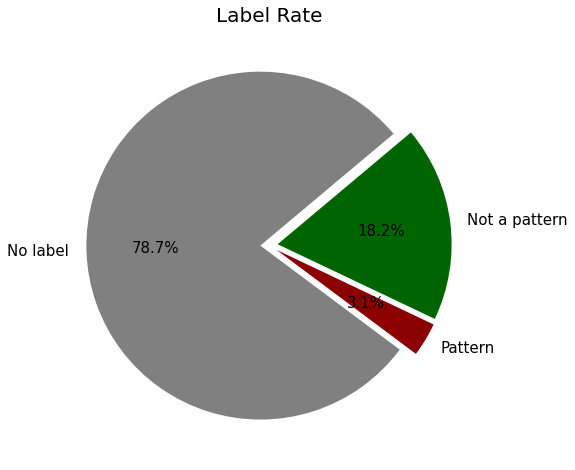

In [6]:
import matplotlib.pyplot as plt

# Data
no_wafers = [total_wafers - labeled, nolabel, nopattern]
uni_pattern = np.unique(data_withpattern['failureNum'], return_counts=True)
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full']

# Plot
fig, labelr = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('white')

# Pie chart
colors = ['grey', 'darkred', 'darkgreen']
explode = (0.05, 0.05, 0.05)
labels = ['No label', 'Pattern', 'Not a pattern']
labelr.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=40, textprops={'fontsize': 15})
labelr.set_title('Label Rate', fontsize=20)

plt.show()


Time to take a look at some of the data with patterns to determine what exactly we are looking for

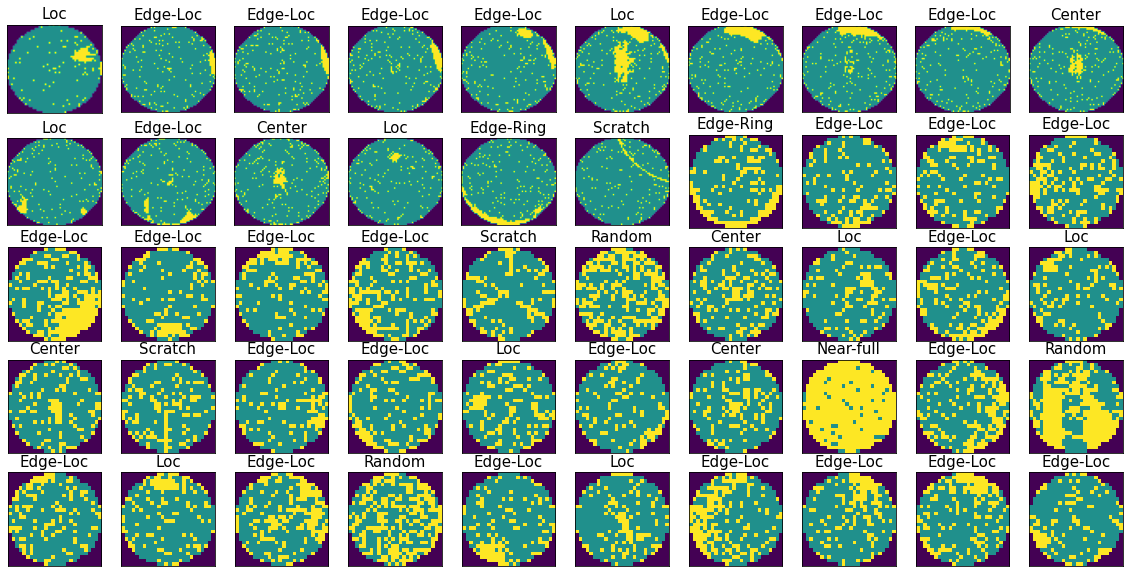

In [7]:
fig, ax = plt.subplots(nrows = 5, ncols = 10, figsize=(20, 10))
fig.patch.set_facecolor('white')
ax = ax.ravel(order='C')
for i in range(50):
    img = data_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(data_withpattern.failureType[i][0][0], fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show() 

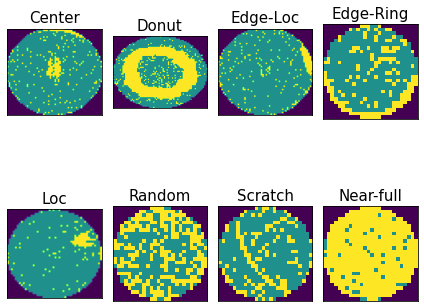

In [8]:
# View the most typical fail pattern for each label
# Values for x were found in the documentation for the dataset
x = [9,340, 3, 16, 0, 25, 84, 37]

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(6, 6))
fig.patch.set_facecolor('white')
ax = ax.ravel(order='C')
for i in range(8):
    img = data_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(data_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

From this we can conclude the labels can be described as follows:
- Center: faults common in the center
- Donut: faults form a ring
- Edge-Loc: faults centralized in one location on the edge
- Edge-Ring: faults alone the edge without being centralized
- Loc: faults faults centralized in one location not on the edge
- Random: no pattern could be found
- Scratch: faults form a line
- Near-full: self explanatory, the faults nearly make up the entirety of the wafer

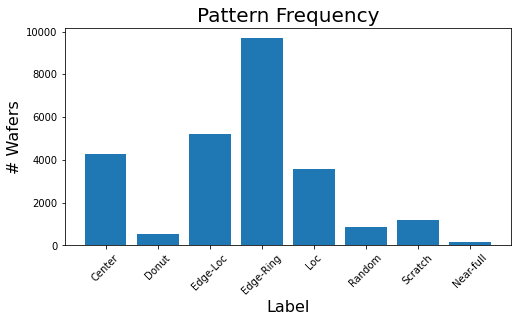

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(8, 4))
fig.patch.set_facecolor('white')

# Bar chart
ax.bar(labels2, uni_pattern[1])
ax.set_title('Pattern Frequency', fontsize=20)
ax.set_xlabel('Label', fontsize=16)
ax.set_ylabel('# Wafers', fontsize=16)
ax.tick_params(axis='x', labelrotation=45)  # Rotate x labels for better readability

plt.show()


We will proceed to divide the wafers into regions in order to find density of faults in each region in order to get us one step closer to being able to categorize our data.

Initally, one might think that we could simply look at the exact positions within the waferMap and directly use that information but waferMap is not consistent in it's sizes.
This may be due to different machines used to scan for faults or different sized chips. Either way, this method is neccessary.

In [10]:
# from our previous evaluation of the dataset, we can see waferMap isn't consistent
# while most are squares, some are rectangular
# in addition, the pixels are clearly visible on some, meaning their resolution is much lower
# lets create new variable to keep track of it's size
def find_dim(x):
    dim0 = np.size(x, axis = 0)
    dim1 = np.size(x, axis = 1)
    return dim0, dim1
data['mapDim']=data.waferMap.apply(find_dim)

max(data.mapDim), min(data.mapDim)

((300, 202), (6, 21))

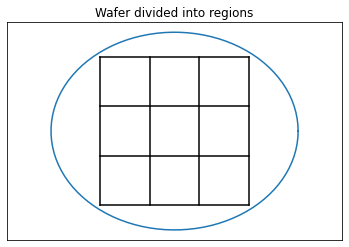

In [11]:
# lets expand on that in order to divide the wafer into regions
# then, looking at each region, we can find where faults are located

# first let us visually represent the region division

# Create wafer map by drawing a circle
an = np.linspace(0, 2 * np.pi, 100)
plt.plot(2.5 * np.cos(an), 2 * np.sin(an))


# Draw lines to represent the regions
plt.plot([-1.5, 1.5], [1.5, 1.5], color='black')  # Horizontal line at y=1.5
plt.plot([-1.5, 1.5], [0.5, 0.5], color='black')  # Horizontal line at y=0.5
plt.plot([-1.5, 1.5], [-0.5, -0.5], color='black')  # Horizontal line at y=-0.5
plt.plot([-1.5, 1.5], [-1.5, -1.5], color='black')  # Horizontal line at y=-1.5



plt.plot([0.5, 0.5], [-1.5, 1.5], color='black')  # Vertical line at x=0.5
plt.plot([1.5, 1.5], [-1.5, 1.5], color='black')  # Vertical line at x=1.5
plt.plot([-0.5, -0.5], [-1.5, 1.5], color='black')  # Vertical line at x=-0.5
plt.plot([-1.5, -1.5], [-1.5, 1.5], color='black')  # Vertical line at x=-1.5

# Set plot properties
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.title("Wafer divided into regions")


# Show plot
plt.show()


In [12]:
def find_density(x):
    return 100*(np.sum(x==2)/np.size(x))

def find_regions(x):
    rows, cols = find_dim(x)

    # Calculate indices to divide the array into 5 equal parts vertically and horizontally
    ind1 = np.arange(0, rows, rows // 5)
    ind2 = np.arange(0, cols, cols // 5)
    
    # Define regions based on the calculated indices
    # Starting with edges
    reg1 = x[ind1[0]:ind1[1], :]
    reg2 = x[:, ind2[4]:]
    reg3 = x[ind1[4]:, :]
    reg4 = x[:, ind2[0]:ind2[1]]
    # Moving to top center
    reg5 = x[ind1[1]:ind1[2], ind2[1]:ind2[2]]
    reg6 = x[ind1[1]:ind1[2], ind2[2]:ind2[3]]
    reg7 = x[ind1[1]:ind1[2], ind2[3]:ind2[4]]
    # Next middle center
    reg8 = x[ind1[2]:ind1[3], ind2[1]:ind2[2]]
    reg9 = x[ind1[2]:ind1[3], ind2[2]:ind2[3]]
    reg10 = x[ind1[2]:ind1[3], ind2[3]:ind2[4]]
    # Now bottom center
    reg11 = x[ind1[3]:ind1[4], ind2[1]:ind2[2]]
    reg12 = x[ind1[3]:ind1[4], ind2[2]:ind2[3]]
    reg13 = x[ind1[3]:ind1[4], ind2[3]:ind2[4]]
    
    # Calculate defect densities for each region
    wafer_defect_density = [find_density(reg1), find_density(reg2), find_density(reg3), find_density(reg4),
                   find_density(reg5), find_density(reg6), find_density(reg7), find_density(reg8),
                   find_density(reg9), find_density(reg10), find_density(reg11), find_density(reg12),
                   find_density(reg13)]
    
    return wafer_defect_density

In [14]:
data_withpattern['feature_density']=data_withpattern.waferMap.apply(find_regions)

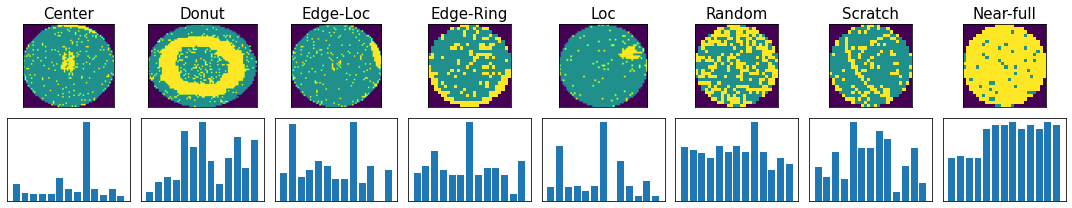

In [15]:
# We can now display these results next to the pictures from earlier showing the most typical fail patterns
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full']

fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(15, 3))
fig.patch.set_facecolor('white')

for i in range(8):
    # Plot wafer map
    img = data_withpattern.waferMap[x[i]]
    ax[0, i].imshow(img)
    ax[0, i].set_title(data_withpattern.failureType[x[i]][0][0], fontsize=15)
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    
    # Plot defect density
    ax[1, i].bar(np.linspace(1, 13, 13), data_withpattern.feature_density[x[i]])
    ax[1, i].set_title('', fontsize=15)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

plt.tight_layout()
plt.show()



The picture above shows the typical fail patterns represented by both their images from earlier as well as feature density graphs for each region 1-13.

In [16]:
# loading libraries
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats


C:\Users\Carson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


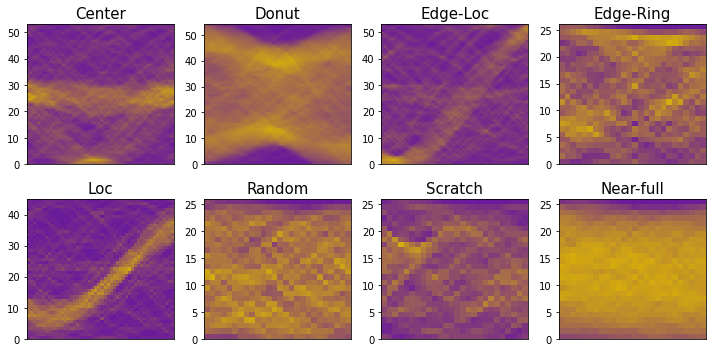

In [17]:
from matplotlib.colors import LinearSegmentedColormap

# Remove random noise prior to geometric feature implementation
# functions very similar to a fourier transformation to reduce noise

# Define the change_val function note that this is also somehow applied to the original data
def change_val(img):
    img[img==1] = 0
    return img

# Applying change_val directly to waferMap in df_withpattern_copy
data_withpattern_copy = data_withpattern.copy(deep=True) # make deep copy so reference is not the same
data_withpattern_copy['new_waferMap'] = data_withpattern_copy.waferMap.apply(change_val)

# Make it look cooler
cmap = LinearSegmentedColormap.from_list('purple_yellow', ['#6a1b9a', '#d4ac0d'])

# Visualizing the new_waferMap
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-full']

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
fig.patch.set_facecolor('white')

ax = ax.ravel(order='C')
for i in range(8):
    img = data_withpattern_copy['new_waferMap'][x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=cmap, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(data_withpattern_copy.failureType[x[i]][0][0], fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 


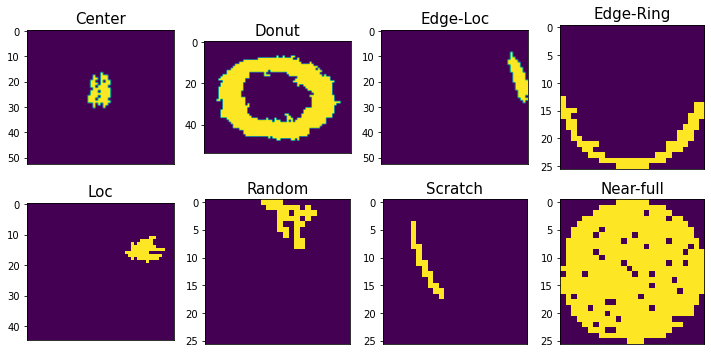

In [18]:

# Creating geometry-based features
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(10, 5))
ax = ax.ravel(order='C')
for i in range(8):
    img = data_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)
    img_labels = measure.label(img, connectivity=1, background=0)
    img_labels = img_labels-1
    if img_labels.max()==0:
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels > -1], axis = None)
        no_region = info_region[0]
    
    zero_img[np.nonzero(img_labels==no_region)] = 2
    ax[i].imshow(zero_img)
    ax[i].set_title(data_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show()

In [19]:

def get_properties(img):
    norm_area = img.shape[0] * img.shape[1]
    norm_perimeter = np.sqrt((img.shape[0]) ** 2 + (img.shape[1]) ** 2)
    
    img_labels = measure.label(img, connectivity=1, background=0)

    if img_labels.max() == 0:
        img_labels[img_labels == 0] = 1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels > 0], axis=None)
        no_region = info_region[0] - 1  # Directly access the first element
    
    p = measure.regionprops(img_labels)

    if no_region < len(p):  # Check if the region exists
        # Normalized area and perimeter of region
        p_area = p[no_region].area / norm_area
        p_perimeter = p[no_region].perimeter / norm_perimeter 

        # Normalized length of both axes
        p_majaxis = p[no_region].major_axis_length / norm_perimeter 
        p_minaxis = p[no_region].minor_axis_length / norm_perimeter  

        # Eccentricity and solidity of the region
        p_ecc = p[no_region].eccentricity  
        p_solidity = p[no_region].solidity  

        return p_area, p_perimeter, p_majaxis, p_minaxis, p_ecc, p_solidity
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

# Create column for geometric features
data_withpattern_copy['feature_geometry'] = data_withpattern_copy.waferMap.apply(get_properties)


What follows is me trying different kinds of algorithms, I figured I could leave them all in to show the ones I tested

In [20]:
# Combining features
data_all = data_withpattern_copy.copy()
region=[data_all.feature_density[i] for i in range(data_all.shape[0])] # 13 features
geometric=[data_all.feature_geometry[i] for i in range(data_all.shape[0])] # 6 features
all_features = np.concatenate((np.array(region), np.array(geometric)), axis = 1) # 19 features

In [21]:
# Generating labels
label=[data_all.failureNum[i] for i in range(data_all.shape[0])]
label=np.array(label)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you already have all_features and labels2
X = all_features
y = label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Trying sklearn for a baseline on both accuracy and time to run
# this was just for testing !

# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)

# Predictions
y_pred_knn_sklearn = knn_classifier.predict(X_test)

# Calculate accuracy for KNN
accuracy_knn_sklearn = accuracy_score(y_test, y_pred_knn_sklearn)
print('Scikit-learn KNN Accuracy:', accuracy_knn_sklearn)

# Initialize SVM classifier
svm_classifier = SVC()

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predictions
y_pred_svm_sklearn = svm_classifier.predict(X_test)

# Calculate accuracy for SVM
accuracy_svm_sklearn = accuracy_score(y_test, y_pred_svm_sklearn)
print('Scikit-learn SVM Accuracy:', accuracy_svm_sklearn)


Scikit-learn KNN Accuracy: 0.7915360501567398
Scikit-learn SVM Accuracy: 0.8019200626959248


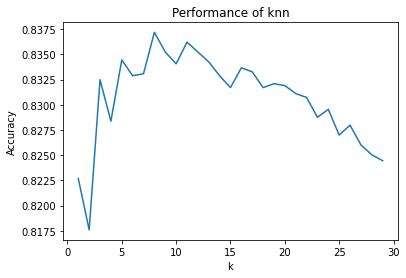

In [ ]:
## This took 57 minutes to run I'm never running it again
#
# removed non weighted KNN
#
# Test knn model across varying ks
#accuracies = []
#ks = range(1, 30)
#for k in ks:
    #knn = KNeighborsClassifier(k=k)
    #knn.fit(X_train, y_train)
    #accuracy = knn.evaluate(X_test, y_test)
    #accuracies.append(accuracy)
# Visualize accuracy vs. k
#fig, ax = plt.subplots()
#ax.plot(ks, accuracies)
#ax.set(xlabel="k",
       #ylabel="Accuracy",
       #title="Performance of knn")
#plt.show()

In [24]:
# WeightedKNN, achieves slightly better accuracy than the sklearn/scratch KNN
class WeightedKNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            weights = [1 / distances[i] if distances[i] != 0 else float('inf') for i in k_indices]  # prevent division by zero
            weighted_votes = np.zeros(np.max(self.y_train) + 1)
            for label, weight in zip(k_nearest_labels, weights):
                weighted_votes[label] += weight
            prediction = np.argmax(weighted_votes)
            y_pred.append(prediction)
        return np.array(y_pred)

# Using the WeightedKNN class
weighted_knn = WeightedKNN(k=9)
weighted_knn.fit(X_train, y_train)
y_pred_weighted_knn = weighted_knn.predict(X_test)

# Calculate the accuracy of the weighted KNN classifier
accuracy_weighted_knn = accuracy_score(y_test, y_pred_weighted_knn)
print("Weighted KNN Accuracy:", accuracy_weighted_knn)


Weighted KNN Accuracy: 0.7989811912225705


In [25]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink = 0.3)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

Confusion matrix, without normalization
Normalized confusion matrix


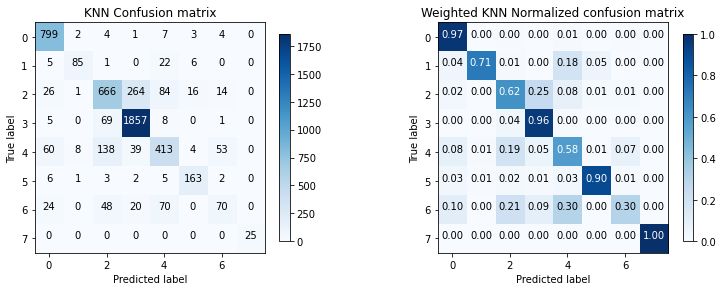

In [26]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_weighted_knn)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(12, 12)) 

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='KNN Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Weighted KNN Normalized confusion matrix')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)  # Adjust padding between subplots

plt.show()
